https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data

## Initialization

In [1]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import mlflow

from constants import (
    DATASET_PATH,
    GROUP_NAME_TO_FEATURE_GROUP,
    ID_COL,
    LABEL_COL,
    FeatureGroup,
)
from enums import SII, Gender
from utils import (
    compute_metrics,
    download_data,
    get_cols_from_df,
    get_experiment_folder,
    load_user_events_df,
    save_image,
    save_metadata,
    save_model,
    save_results,
    save_text,
)

mlflow.set_tracking_uri("http://localhost:5000")

## Data Download

In [2]:
download_data()

Kaggle credentials set.


In [4]:
data_dictionary = pd.read_csv(f"{DATASET_PATH}data_dictionary.csv")
data_dictionary

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [8]:
FEATURE_GROUP_TO_COLUMNS = {
    v: data_dictionary.loc[data_dictionary["Instrument"] == k]["Field"].to_list()
    for k, v in GROUP_NAME_TO_FEATURE_GROUP.items()
}

In [5]:
# Numerical Features
NUMERICAL_FEATURES = (
    data_dictionary["Field"]
    .loc[
        data_dictionary["Type"].isin(["int", "float"])
        & ~data_dictionary["Field"].isin(
            FEATURE_GROUP_TO_COLUMNS[FeatureGroup.INTERNET_ADDICTION_TEST]
        )
    ]
    .to_list()
)
# Categorical Features
CATEGORICAL_FEATURES = (
    data_dictionary["Field"]
    .loc[
        data_dictionary["Type"].isin(["str", "categorical int"])
        & (data_dictionary["Field"] != ID_COL)
        & ~data_dictionary["Field"].isin(
            FEATURE_GROUP_TO_COLUMNS[FeatureGroup.INTERNET_ADDICTION_TEST]
        )
    ]
    .to_list()
)

In [9]:
def pre_processing(df: pd.DataFrame) -> pd.DataFrame:
    df["Basic_Demos-Sex"] = df["Basic_Demos-Sex"].apply(lambda x: Gender(x).name)
    df[LABEL_COL] = df[LABEL_COL].fillna(SII.SII_UNKNOWN.value).astype(int)
    for col in df.columns:
        if col in CATEGORICAL_FEATURES:
            df[col] = df[col].astype("category")
    return df

def get_feature_description(feature: str) -> str:
    row = data_dictionary.loc[data_dictionary["Field"] == feature].iloc[0]
    return f'[{row["Instrument"]}] {row["Description"]}'

In [10]:
data_dictionary.loc[
    data_dictionary["Field"].isin(CATEGORICAL_FEATURES)
    & (data_dictionary["Value Labels"] != "")
][["Field", "Value Labels"]].groupby("Value Labels").agg(list)

,Field
Value Labels,
"0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day",[PreInt_EduHx-computerinternet_hoursday]
"0=Male, 1=Female",[Basic_Demos-Sex]
"0=Needs Improvement, 1=Healthy Fitness Zone","[FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRL..."
"1=Small, 2=Medium, 3=Large",[BIA-BIA_Frame_num]
"1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional",[BIA-BIA_Activity_Level_num]
"1=Weak, 2=Normal, 3=Strong","[FGC-FGC_GSND_Zone, FGC-FGC_GSD_Zone]"


> Data Questions
* How to handle missing labels
* How to model Season
* How to model User Events
> Modeling Hypotesis
* Multi Class Classification
* Binary Classification, spliting in bands
* Regression using `PCIAT-PCIAT_Total`
> TODO
* Evaluation 

## EDA

### Features Data

In [11]:
df_train = pd.read_csv(f"{DATASET_PATH}train.csv")
df_train = pre_processing(df_train)
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,MALE,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2
1,000fd460,Summer,9,MALE,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,00105258,Summer,10,FEMALE,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0
3,00115b9f,Winter,9,MALE,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1
4,0016bb22,Spring,18,FEMALE,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,MALE,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1
3956,ffa9794a,Winter,10,MALE,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,4
3957,ffcd4dbd,Fall,11,MALE,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1
3958,ffed1dd5,Spring,13,MALE,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0


In [12]:
df_train.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,...,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,sii
count,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,...,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3960.000000
mean,10.433586,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,...,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.637374
std,3.574648,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,...,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.705471
min,5.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000
25%,8.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000
50%,10.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000
75%,13.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,6.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,4.000000
max,22.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,28.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,4.000000


In [13]:
df_train[LABEL_COL].value_counts(dropna=False)

sii
0    1594
4    1224
1     730
2     378
3      34
Name: count, dtype: int64

### Events Data

In [14]:
temporal_ids = [x.split("=")[-1] for x in os.listdir(f"{DATASET_PATH}series_train.parquet/")]
len(temporal_ids)

996

In [15]:
df_train["has_temporal_data"] = df_train[ID_COL].apply(lambda x: x in temporal_ids)
# TODO: add it as numerical feature

In [16]:
df_train[[LABEL_COL, "has_temporal_data"]].value_counts(dropna=False)

sii  has_temporal_data
4    False                1224
0    False                1011
     True                  583
1    False                 464
     True                  266
2    False                 241
     True                  137
3    False                  24
     True                   10
Name: count, dtype: int64

In [17]:
df_events = load_user_events_df(temporal_ids[0])
df_events

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.331432,0.630964,-0.272057,0.160357,-26.006044,0.0,16.666666,4176.0,61020000000000,5,2,108.0
1,1,0.323099,0.283359,-0.803672,0.102221,-57.913212,0.0,29.000000,4176.0,61025000000000,5,2,108.0
2,2,0.212995,0.176120,-0.928125,0.061089,-71.058197,0.0,3.333333,4176.0,61030000000000,5,2,108.0
3,3,-0.330443,-0.382943,-0.316458,0.096627,-27.220118,0.0,6.666667,4176.0,61035000000000,5,2,108.0
4,4,-0.589219,-0.013646,-0.243229,0.092851,-18.073689,0.0,10.000000,4176.0,61040000000000,5,2,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10665,10665,-0.116563,0.749531,-0.549323,0.059857,-34.132866,0.0,5.250000,3824.0,34670000000000,5,2,157.0
10666,10666,0.350260,0.669766,-0.487969,0.029691,-31.824656,0.0,8.000000,3824.0,34675000000000,5,2,157.0
10667,10667,0.334688,-0.566354,-0.331589,0.101461,-25.376301,0.0,13.500000,3824.0,34680000000000,5,2,157.0
10668,10668,0.177943,-0.597031,-0.163073,0.093620,-17.816175,0.0,19.000000,3824.0,34685000000000,5,2,157.0


## Train

In [18]:
experiment_name = "all numerical + categorical without season feats regression"
features = [
    x for x in NUMERICAL_FEATURES + CATEGORICAL_FEATURES if not x.endswith("Season")
]
test_size = 0.2
random_state = 42

assert experiment_name
assert features

In [19]:
df = get_cols_from_df(df_train, features)
train, test = train_test_split(
    df,
    test_size=test_size,
    random_state=random_state,
)
X_train = train.drop(columns=[ID_COL, LABEL_COL])
y_train = train[LABEL_COL]
X_test = test.drop(columns=[ID_COL, LABEL_COL])
y_test = test[LABEL_COL]

In [20]:
X_train.shape

(3168, 48)

In [21]:
parameters = {
    "objective": "multiclass",
    "num_class": 5, # TODO: fix
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_leaves": 12,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "boosting_type": "gbdt",
    "verbosity": 10,
    "random_state": random_state,
}
model = lgb.LGBMClassifier(**parameters)

In [22]:
experiment_metadata = {
    "random_state": random_state,
    "test_size": test_size,
    "model_features": features,
    "model_parameters": parameters,
    "model_type": model.__class__.__name__,
}

model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=[x for x in X_train.columns if x in CATEGORICAL_FEATURES],
)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.828993
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.201474
[LightGBM] [Debug] init for col-wise cost 0.000947 seconds, init for row-wise cost 0.000673 seconds
[LightGBM] [Info] Auto-choosing row-wise mult

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.01, max_depth=8, metric='multi_logloss',
               num_class=5, num_leaves=12, objective='multiclass',
               random_state=42, verbosity=10)

## Evaluation

2024/10/17 01:14:58 INFO mlflow.tracking.fluent: Experiment with name 'all numerical + categorical without season feats regression' does not exist. Creating a new experiment.
2024/10/17 01:15:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

2024/10/17 01:15:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-crane-82 at: http://localhost:5000/#/experiments/1/runs/ec347354f7324e5b9dde3e774f3ca17c.
2024/10/17 01:15:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


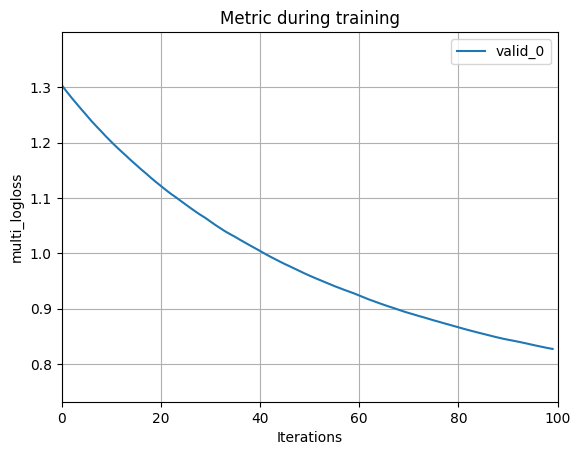

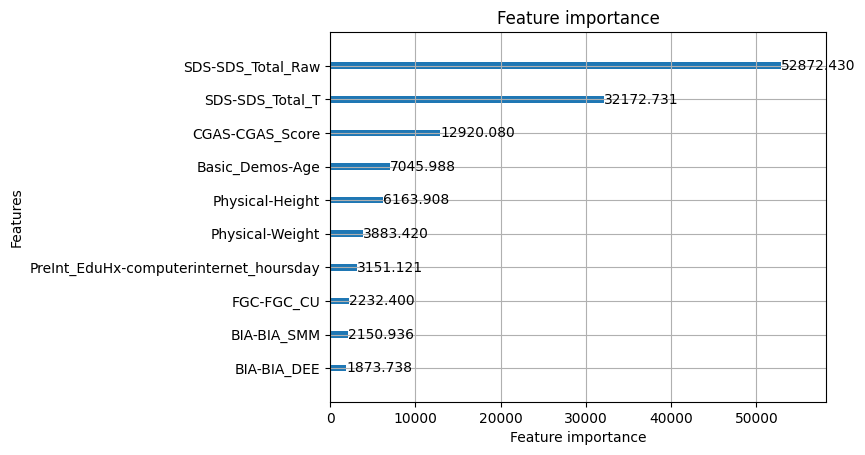

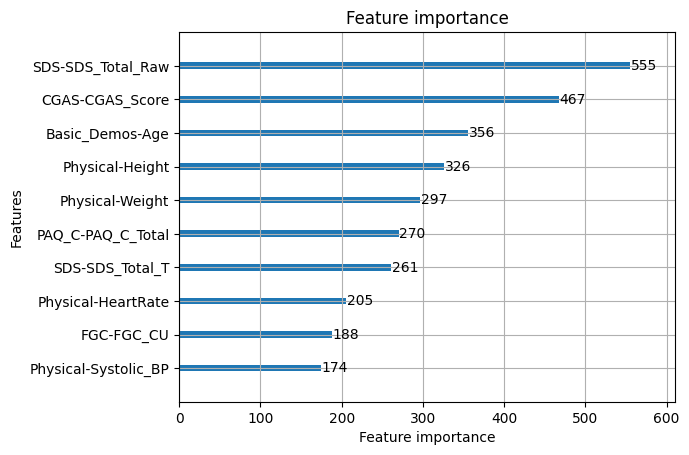

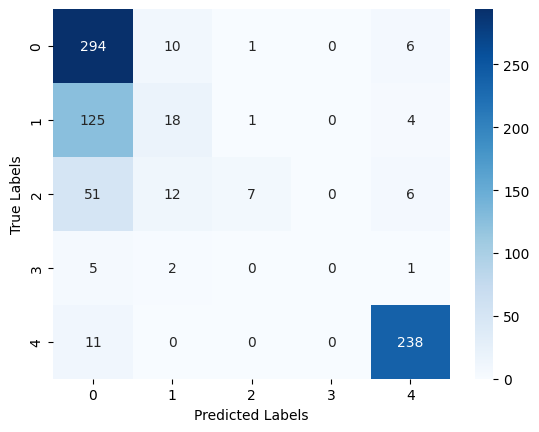

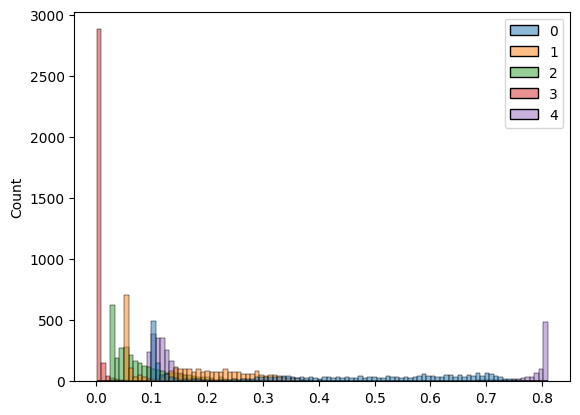

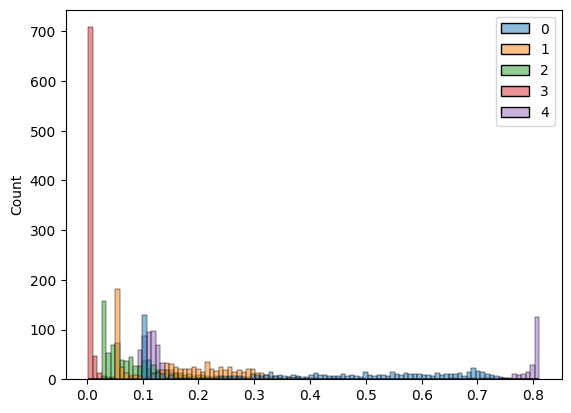

In [23]:
save_results(
    model=model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    experiment_name=experiment_name,
    experiment_metadata=experiment_metadata,
    save_locally=False,
    save_on_mlflow=True,
)

In [24]:
get_feature_description("SDS-SDS_Total_Raw")

'[Sleep Disturbance Scale] Total Raw Score'